# Testing EfficientNet 

In [1]:
import tensorflow as tf
import data.imageReading as ir
from fairness import fairnessMetrics as fm
from model import model as m
from model import utils as utils
from model import biasMitigation as mit
from model import evaluation as ev
from tuning import callbacks as cb
import datetime
import os
import numpy as np

In [2]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

image_size = (300,300)
batch_size = 128
epochs = 20
#(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", image_size, batch_size, preprocess_input)
#(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace", image_size, batch_size, preprocess_input)
(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces_split", image_size, batch_size, preprocess_input, None, False, False)
(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace_split", image_size, batch_size, preprocess_input, None, False, False)


options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
ds_train = ds_train.with_options(options)
ds_val = ds_val.with_options(options)
ds_test = ds_test.with_options(options)

Found 3916 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Count classes: (2052, 1864, 256, 233, 258, 234)
Found 78158 images belonging to 2 classes.
Found 9769 images belonging to 2 classes.
Found 9771 images belonging to 2 classes.
Count classes: (36736, 41422, 4592, 5177, 4592, 5179)


## Find learning rate

In [3]:
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
                           loss="binary_crossentropy", 
                           metrics="accuracy")


Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

Epoch 1/200
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
10/10 - 73s - loss: 0.9316 - accuracy: 0.5250 - 73s/epoch - 7s/step
Epoch 2/200
10/10 - 6s - loss: 0.8354 - accuracy: 0.5531 - 6s/epoch - 623ms/step
Epoch 3/200
10/10 - 6s - loss: 0.9152 - accuracy: 0.5156 - 6s/epoch - 626ms/step
Epoch 4/200
10/10 - 6s - loss: 0.9118 - accuracy: 0.5000 - 6s/epoch - 622ms/step
Epoch 5/200
10/10 - 6s - loss: 0.8824 - accuracy: 0.5188 - 6s/epoch - 624ms/step
Epoch 6/200
10/10 - 6s - loss: 0.9587 - accuracy: 0.5031 - 6s/epoch - 625ms/step
Epoch 7/200
10/10 - 6s - loss: 0.8488 - accuracy: 0.5156 - 6s/epoch - 622ms/step
Epoch 8/200
10/10 - 6s - loss: 0.8871 - accuracy: 0.5156 - 6s/epoch - 626ms/step
Epoch 9/200
10/10 - 6s - loss: 0.8823 - accuracy: 0.5281 - 6s/epoch - 629ms/step
Epoch 10/200
10/10 - 6s - loss: 0.9216 - accuracy: 0.5031 - 6s/epoch - 635ms/step
Epoch 11/200
10/

Epoch 99/200
10/10 - 6s - loss: 1.6804 - accuracy: 0.5033 - 6s/epoch - 608ms/step
Epoch 100/200
10/10 - 6s - loss: 1.3627 - accuracy: 0.4500 - 6s/epoch - 601ms/step


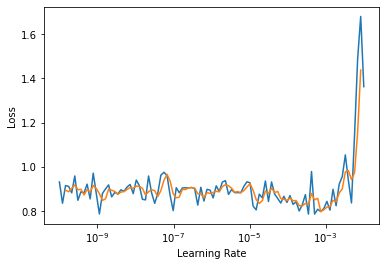

In [4]:
epochs = 200
train_input = []
train_output = []
nr_batches = 10

model.fit(ds_train, steps_per_epoch=nr_batches, callbacks=[cb.LerningRateCallback(100, nr_batches)], epochs=epochs, verbose=2)

## 5-Fold Cross Validation EfficientNet without Transfer Learning (unweighted)

In [5]:
preprocess = tf.keras.applications.efficientnet.preprocess_input
nr_of_splits = 5

ds_train = tf.keras.utils.image_dataset_from_directory(
    "/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces",
    label_mode="binary",
    image_size=(300, 300),
    shuffle=True,
    color_mode="rgb",
    batch_size=128
)

ds_train = ds_train.map(lambda x, y: (preprocess(x), y))

train_splits = []
for i in range(0,nr_of_splits):
    train_splits.append(ds_train.skip(i*8).take(8))

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metrics_list = m.metrics_list()
    
weights = model.get_weights()

history = []
for i in range(0,nr_of_splits):
    ds_val_fold = train_splits.pop(0)
    ds_train_fold = train_splits[0]
    for j in range(1, nr_of_splits-1):
        ds_train_fold = ds_train_fold.concatenate(train_splits[j])

    model.set_weights(weights)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), 
                               loss="binary_crossentropy", metrics=metrics_list)

    schedulercb = tf.keras.callbacks.LearningRateScheduler(utils.scheduler)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystop_callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, baseline=0.7)

    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
    ds_val_fold = ds_val_fold.with_options(options)
    ds_train_fold = ds_train_fold.with_options(options)
    
    test_results = model.fit(ds_train_fold, callbacks=[schedulercb,tensorboard_callback,earlystop_callback], epochs=20, validation_data=ds_val_fold)

    history.append(test_results.history)    
    train_splits.append(ds_val_fold)    
    
history = ev.kfoldCrossValidation(history)

Found 4897 files belonging to 2 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
31/31 [==============================] - 191s 2s/step - loss: 0.6540 - accuracy: 0.6920 - true_positives_42: 1296.0000 - true_negatives_28: 1384.0000 - false_positives_34: 644.0000 - false_negatives_36: 549.0000 - true_positive_rate: 0.7024 - true_negative_rate: 0.6824 - false_positive_rate: 0.3176 - false_negative_rate: 0.2976 - positive_predicted_value: 0.6680 - false_discovery_rate: 0.3320 - negative_predicted_value: 0.7160 - false_omission_rate: 0.2840 - binary_demographic_parity_diff: 7.0000 - demographic_parity: 1940.0000 - binary_equalized_odds_diff: -0.0200 - binary_proportional_parity_diff: 0.0018 - propor

KeyboardInterrupt: 

In [16]:
import tensorflow as tf

dataset = tf.data.Dataset.range(9).batch(3)

for i in dataset:
    print(i)

for i in dataset.skip(3).take(8):
    print(i)   

tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)


## Test EfficientNet without Transfer Learning (unweighted) 

In [3]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_unweighted"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_unweighted.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
31/31 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.5894 - true_positives: 1143.0000 - true_negatives: 1165.0000 - false_positives: 887.0000 - false_negatives: 721.0000 - true_positive_rate: 0.6132 - true_negative_rate: 0.5677 - false_positive_rate: 0.4323 - false_negative_rate: 0.3868 - positive_predicted_value: 0.5631 - false_discovery_rate: 0.4369 - negative_predicted_value: 0.6177 - false_omission_rate: 0.3823 - binary_demographic_parity_diff: 144.0000 - demographic_parity: 2030.0000 - binary_equalized_odds_diff: -0.0455 - binary_proportional_parity_diff: 0.0368 - proportional_parity: 0.5184 - binary_predictive_rate_parity_diff: -0.0547 - predictive_rate_parity: 0.5631 - binary_accuracy_parity_diff: 0.1788 - accuracy_parity: 0.5894 - false_negative_rate_parity_diff: 0.045

KeyboardInterrupt: 

In [ ]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)

# FairFace training

In [ ]:
class_weight = mit.findClassWeights(fftrain_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ffds_train, fftrain_batches, ffds_val, ffval_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_FairFace.h5")

Weight for class 0: 1.06
Weight for class 1: 0.94
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
611/611 [==============================] - 847s 1s/step - loss: 0.4872 - accuracy: 0.7642 - true_positives: 32335.0000 - true_negatives: 27393.0000 - false_positives: 9343.0000 - false_negatives: 9087.0000 - true_positive_rate: 0.7806 - true_negative_rate: 0.7457 - false_positive_rate: 0.2543 - false_negative_rate: 0.2194 - positive_predicted_value: 0.7758 - false_discovery_rate: 0.2242 - negative_predicted_value: 0.7509 - false_omission_rate: 0.2491 - binary_demographic_parity_diff: 5198.0000 - demographic_parity: 41678.0000 - binary_equalized_odds_diff: -0.0350 - binary_proportional_parity_diff: 0.0665 - proportional_parity: 0.5333 - binary_predictive_rate_parity_diff: 0.0249 - predictive_rate_parity: 0.7758 - binary_accuracy_parity_diff: 0.5284 - accuracy_parity: 0.7642 - false_negative_rate_parity

In [ ]:
test_predict, test_labels, dir_name = ev.testModel(model, ffds_test, fftest_batches, dir_name)
ev.testModelWithThresholdChange(model, ffds_val, ffval_batches, test_predict, test_labels, dir_name)

In [5]:
model.summary()
print(len(model.layers))

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_FairFace.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 301, 301, 3)  0           ['normalization[0][0]']      

# Transfer learning

In [7]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = utils.loadModel(dir_name + "/EfficientNet_FairFace.h5", m.metrics_dict())
    metric_list = m.metrics_list()
    
utils.freezeCertainLayers(model, 200)    
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)

utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, class_weight)

print("Make folder...")
dir_name_transfer = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_transfer"
os.mkdir(dir_name_transfer)

print("Name directory: " + dir_name)
utils.saveModel(model, dir_name_transfer + "/EfficientNet_transfer.h5")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 168 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 168 all-reduces with algorithm = nccl, num_packs = 1
62/62 [==============================] - 130s 609ms/step - loss: 0.6125 - accuracy: 0.7035 - true_positives_61: 1421.0000 - true_negatives_40: 1334.0000 - false_positives_49: 718.0000 - false_negatives_52: 443.0000 - true_positive_rate: 0.7623 - true_negative_rate: 0.6501 - false_positive_rate: 0.3499 - false_negative_rate: 0.2377 - positive_predicted_value: 0.6643 - false_discovery_rate: 0.3357 - negative_predicted_value: 0.7507 - false_omission_rate: 0.2493 - binary_demographic_parity_diff: 362.0000 - demographic_parity: 2139.0000 - binary_equalized_odds_diff: -0.1122 - binary_proportional_parity_diff: 0.0924 - proportional_parity: 0.5462 - binary_predictive_rate_parity_diff: -0.0864 - predictive_rate_parity: 0.6643 - binary_accuracy_parity_diff: 0.4070 - accuracy_parity: 0.7035 - false_negative_rat

sc
Epoch 5/20
62/62 [==============================] - 14s 230ms/step - loss: 0.2853 - accuracy: 0.8749 - true_positives_61: 1601.0000 - true_negatives_40: 1825.0000 - false_positives_49: 227.0000 - false_negatives_52: 263.0000 - true_positive_rate: 0.8589 - true_negative_rate: 0.8894 - false_positive_rate: 0.1106 - false_negative_rate: 0.1411 - positive_predicted_value: 0.8758 - false_discovery_rate: 0.1242 - negative_predicted_value: 0.8740 - false_omission_rate: 0.1260 - binary_demographic_parity_diff: -260.0000 - demographic_parity: 1828.0000 - binary_equalized_odds_diff: 0.0305 - binary_proportional_parity_diff: -0.0664 - proportional_parity: 0.4668 - binary_predictive_rate_parity_diff: 0.0018 - predictive_rate_parity: 0.8758 - binary_accuracy_parity_diff: 0.7497 - accuracy_parity: 0.8749 - false_negative_rate_parity_diff: -0.0305 - false_positive_rate_parity_diff: 0.0305 - binary_negative_predictive_rate_parity_diff: -0.0018 - negative_predictive_rate_parity: 0.8758 - binary_spec

sc
Epoch 9/20
62/62 [==============================] - 14s 229ms/step - loss: 0.1872 - accuracy: 0.9226 - true_positives_61: 1689.0000 - true_negatives_40: 1924.0000 - false_positives_49: 128.0000 - false_negatives_52: 175.0000 - true_positive_rate: 0.9061 - true_negative_rate: 0.9376 - false_positive_rate: 0.0624 - false_negative_rate: 0.0939 - positive_predicted_value: 0.9296 - false_discovery_rate: 0.0704 - negative_predicted_value: 0.9166 - false_omission_rate: 0.0834 - binary_demographic_parity_diff: -282.0000 - demographic_parity: 1817.0000 - binary_equalized_odds_diff: 0.0315 - binary_proportional_parity_diff: -0.0720 - proportional_parity: 0.4640 - binary_predictive_rate_parity_diff: 0.0129 - predictive_rate_parity: 0.9296 - binary_accuracy_parity_diff: 0.8453 - accuracy_parity: 0.9226 - false_negative_rate_parity_diff: -0.0315 - false_positive_rate_parity_diff: 0.0315 - binary_negative_predictive_rate_parity_diff: -0.0129 - negative_predictive_rate_parity: 0.9296 - binary_spec

Testing Model
-------------
8/8 - 7s - 7s/epoch - 874ms/step
Plot Histogram...


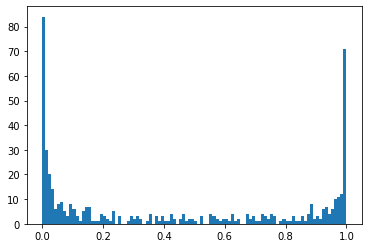

Plot ROC...


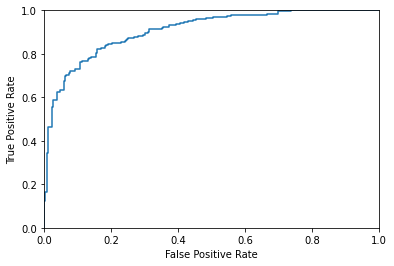

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

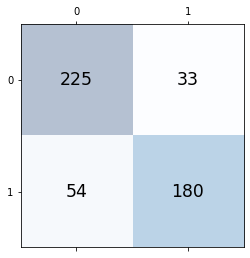

Plot Results...


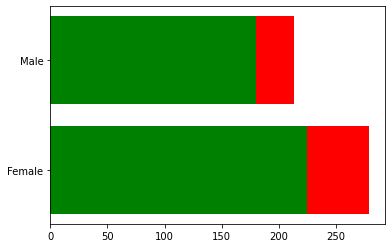


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.823
    
    True positives: 180.000
    False positives: 33.000
    
    True negatives: 225.000
    False negatives: 54.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.769
    True negative rate tn/(tn+fp): 0.872
    
    False negative rate fn/(tp+fn): 0.231
    False positive rate fp/(tn+fp): 0.128
    
    Positive predicted value tp/(tp+fp): 0.845
    False discovery rate fp/(tp+fp): 0.155
    
    Negative predicted value tn/(tn+fn): 0.806
    False omission rate fn/(tn+fn): 0.194
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -66.000
    Demographic parity tp+fp: 213.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.103
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.134
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.433
    
    Binary predictive rate parity diff 

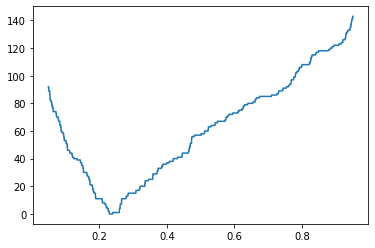

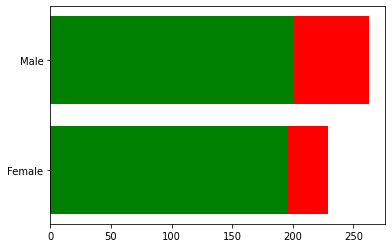


    Test results (Equal True):
    -------------
    
    Accuracy: 0.807
    
    True positives: 201.000
    False positives: 62.000
    
    True negatives: 196.000
    False negatives: 33.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.859
    True negative rate tn/(tn+fp): 0.760
    
    False negative rate fn/(tp+fn): 0.141
    False positive rate fp/(tn+fp): 0.240
    
    Positive predicted value tp/(tp+fp): 0.764
    False discovery rate fp/(tp+fp): 0.236
    
    Negative predicted value tn/(tn+fn): 0.856
    False omission rate fn/(tn+fn): 0.144
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 34.000
    Demographic parity tp+fp: 263.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.099
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.069
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.535
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn/

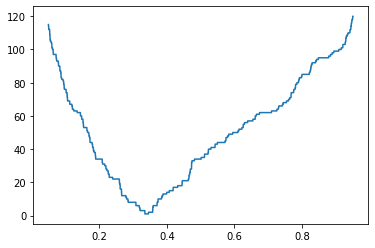

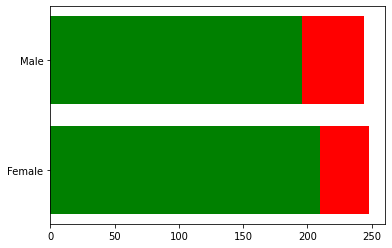


    Test results (Equal False):
    -------------
    
    Accuracy: 0.825
    
    True positives: 196.000
    False positives: 48.000
    
    True negatives: 210.000
    False negatives: 38.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.838
    True negative rate tn/(tn+fp): 0.814
    
    False negative rate fn/(tp+fn): 0.162
    False positive rate fp/(tn+fp): 0.186
    
    Positive predicted value tp/(tp+fp): 0.803
    False discovery rate fp/(tp+fp): 0.197
    
    Negative predicted value tn/(tn+fn): 0.847
    False omission rate fn/(tn+fn): 0.153
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -4.000
    Demographic parity tp+fp: 244.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.024
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.008
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.496
    
    Binary predictive rate parity diff (tp/(tp+fp))-(t

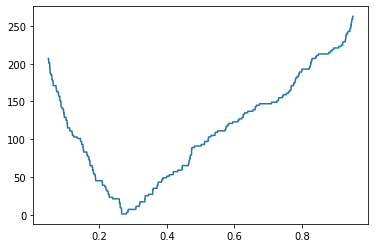

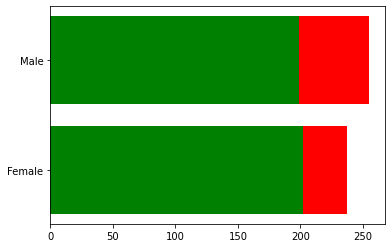


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.815
    
    True positives: 199.000
    False positives: 56.000
    
    True negatives: 202.000
    False negatives: 35.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.850
    True negative rate tn/(tn+fp): 0.783
    
    False negative rate fn/(tp+fn): 0.150
    False positive rate fp/(tn+fp): 0.217
    
    Positive predicted value tp/(tp+fp): 0.780
    False discovery rate fp/(tp+fp): 0.220
    
    Negative predicted value tn/(tn+fn): 0.852
    False omission rate fn/(tn+fn): 0.148
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 18.000
    Demographic parity tp+fp: 255.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.067
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.037
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.518
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn

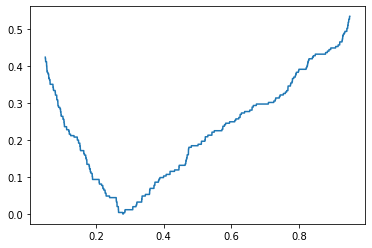

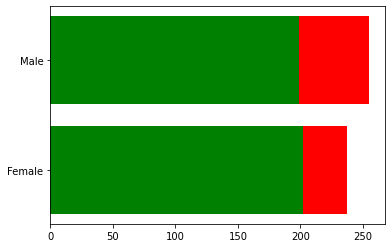


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.815
    
    True positives: 199.000
    False positives: 56.000
    
    True negatives: 202.000
    False negatives: 35.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.850
    True negative rate tn/(tn+fp): 0.783
    
    False negative rate fn/(tp+fn): 0.150
    False positive rate fp/(tn+fp): 0.217
    
    Positive predicted value tp/(tp+fp): 0.780
    False discovery rate fp/(tp+fp): 0.220
    
    Negative predicted value tn/(tn+fn): 0.852
    False omission rate fn/(tn+fn): 0.148
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 18.000
    Demographic parity tp+fp: 255.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.067
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.037
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.518
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn/

<Figure size 432x288 with 0 Axes>

In [8]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name_transfer)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name_transfer)

# Test EfficientNet without Transfer Learning (weighted)

In [6]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, class_weight)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_weighted"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_weighted.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
31/31 [==============================] - 168s 2s/step - loss: 0.7451 - accuracy: 0.6307 - true_positives_42: 1180.0000 - true_negatives_28: 1290.0000 - false_positives_34: 775.0000 - false_negatives_36: 671.0000 - true_positive_rate: 0.6375 - true_negative_rate: 0.6247 - false_positive_rate: 0.3753 - false_negative_rate: 0.3625 - positive_predicted_value: 0.6036 - false_discovery_rate: 0.3964 - negative_predicted_value: 0.6578 - false_omission_rate: 0.3422 - binary_demographic_parity_diff: -6.0000 - demographic_parity: 1955.0000 - binary_equalized_odds_diff: -0.0128 - binary_proportional_parity_diff: -0.0015 - proportional_parity: 0.4992 - binary_predictive_rate_parity_diff: -0.0542 - predictive_rate_parity: 0.6036 - binary_accuracy_parity_diff: 0.2615 - accuracy_parity: 0.6307 - false_negative_rate_p

sc
Epoch 5/20
31/31 [==============================] - 39s 1s/step - loss: 0.1598 - accuracy: 0.9372 - true_positives_42: 1754.0000 - true_negatives_28: 1916.0000 - false_positives_34: 129.0000 - false_negatives_36: 117.0000 - true_positive_rate: 0.9375 - true_negative_rate: 0.9369 - false_positive_rate: 0.0631 - false_negative_rate: 0.0625 - positive_predicted_value: 0.9315 - false_discovery_rate: 0.0685 - negative_predicted_value: 0.9424 - false_omission_rate: 0.0576 - binary_demographic_parity_diff: -150.0000 - demographic_parity: 1883.0000 - binary_equalized_odds_diff: -5.4729e-04 - binary_proportional_parity_diff: -0.0383 - proportional_parity: 0.4808 - binary_predictive_rate_parity_diff: -0.0110 - predictive_rate_parity: 0.9315 - binary_accuracy_parity_diff: 0.8744 - accuracy_parity: 0.9372 - false_negative_rate_parity_diff: 5.4728e-04 - false_positive_rate_parity_diff: -5.4728e-04 - binary_negative_predictive_rate_parity_diff: 0.0110 - negative_predictive_rate_parity: 0.9315 - b

sc
Epoch 9/20
31/31 [==============================] - 39s 1s/step - loss: 0.0534 - accuracy: 0.9811 - true_positives_42: 1846.0000 - true_negatives_28: 1996.0000 - false_positives_34: 38.0000 - false_negatives_36: 36.0000 - true_positive_rate: 0.9809 - true_negative_rate: 0.9813 - false_positive_rate: 0.0187 - false_negative_rate: 0.0191 - positive_predicted_value: 0.9798 - false_discovery_rate: 0.0202 - negative_predicted_value: 0.9823 - false_omission_rate: 0.0177 - binary_demographic_parity_diff: -148.0000 - demographic_parity: 1884.0000 - binary_equalized_odds_diff: 4.4614e-04 - binary_proportional_parity_diff: -0.0378 - proportional_parity: 0.4811 - binary_predictive_rate_parity_diff: -0.0025 - predictive_rate_parity: 0.9798 - binary_accuracy_parity_diff: 0.9622 - accuracy_parity: 0.9811 - false_negative_rate_parity_diff: -4.4619e-04 - false_positive_rate_parity_diff: 4.4619e-04 - binary_negative_predictive_rate_parity_diff: 0.0025 - negative_predictive_rate_parity: 0.9798 - bina

Testing Model
-------------
Plot Histogram...


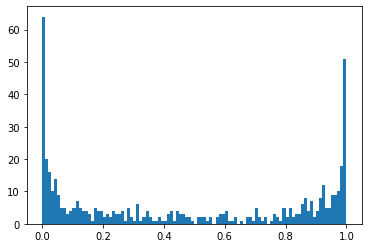

Plot ROC...


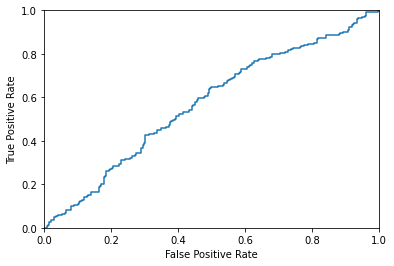

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

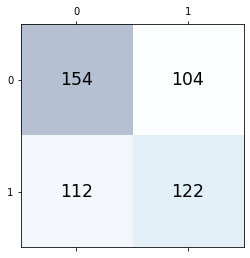

Plot Results...


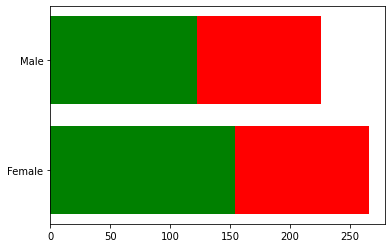


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.561
    
    True positives: 122.000
    False positives: 104.000
    
    True negatives: 154.000
    False negatives: 112.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.521
    True negative rate tn/(tn+fp): 0.597
    
    False negative rate fn/(tp+fn): 0.479
    False positive rate fp/(tn+fp): 0.403
    
    Positive predicted value tp/(tp+fp): 0.540
    False discovery rate fp/(tp+fp): 0.460
    
    Negative predicted value tn/(tn+fn): 0.579
    False omission rate fn/(tn+fn): 0.421
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -40.000
    Demographic parity tp+fp: 226.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.076
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.081
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.459
    
    Binary predictive rate parity dif

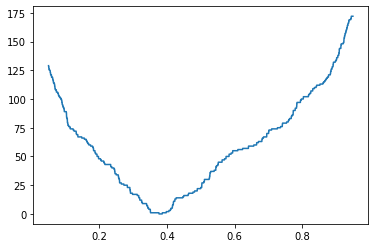

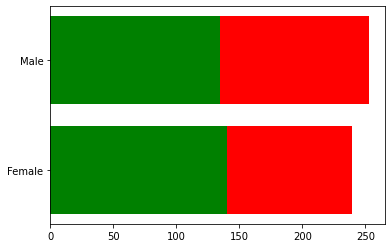


    Test results (Equal True):
    -------------
    
    Accuracy: 0.559
    
    True positives: 135.000
    False positives: 118.000
    
    True negatives: 140.000
    False negatives: 99.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.577
    True negative rate tn/(tn+fp): 0.543
    
    False negative rate fn/(tp+fn): 0.423
    False positive rate fp/(tn+fp): 0.457
    
    Positive predicted value tp/(tp+fp): 0.534
    False discovery rate fp/(tp+fp): 0.466
    
    Negative predicted value tn/(tn+fn): 0.586
    False omission rate fn/(tn+fn): 0.414
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 14.000
    Demographic parity tp+fp: 253.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.034
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.028
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.514
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn

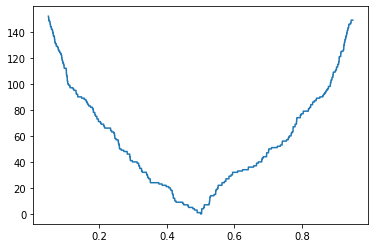

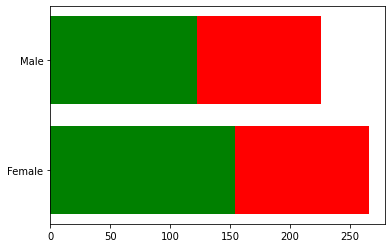


    Test results (Equal False):
    -------------
    
    Accuracy: 0.561
    
    True positives: 122.000
    False positives: 104.000
    
    True negatives: 154.000
    False negatives: 112.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.521
    True negative rate tn/(tn+fp): 0.597
    
    False negative rate fn/(tp+fn): 0.479
    False positive rate fp/(tn+fp): 0.403
    
    Positive predicted value tp/(tp+fp): 0.540
    False discovery rate fp/(tp+fp): 0.460
    
    Negative predicted value tn/(tn+fn): 0.579
    False omission rate fn/(tn+fn): 0.421
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -40.000
    Demographic parity tp+fp: 226.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.076
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.081
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.459
    
    Binary predictive rate parity diff (tp/(tp+fp)

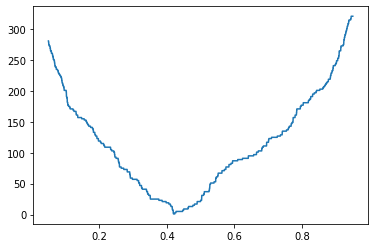

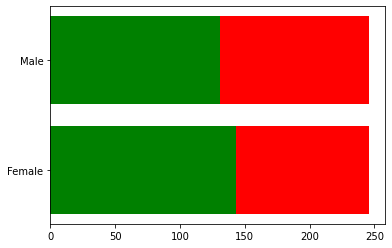


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.557
    
    True positives: 131.000
    False positives: 115.000
    
    True negatives: 143.000
    False negatives: 103.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.560
    True negative rate tn/(tn+fp): 0.554
    
    False negative rate fn/(tp+fn): 0.440
    False positive rate fp/(tn+fp): 0.446
    
    Positive predicted value tp/(tp+fp): 0.533
    False discovery rate fp/(tp+fp): 0.467
    
    Negative predicted value tn/(tn+fn): 0.581
    False omission rate fn/(tn+fn): 0.419
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 0.000
    Demographic parity tp+fp: 246.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.006
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.000
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.500
    
    Binary predictive rate parity diff (tp/(tp+fp))-(t

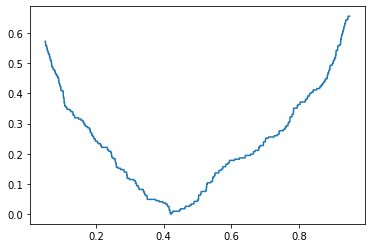

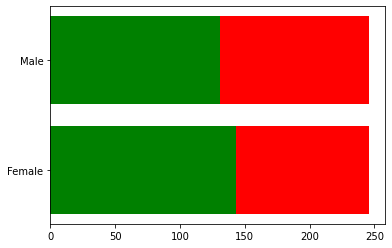


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.557
    
    True positives: 131.000
    False positives: 115.000
    
    True negatives: 143.000
    False negatives: 103.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.560
    True negative rate tn/(tn+fp): 0.554
    
    False negative rate fn/(tp+fn): 0.440
    False positive rate fp/(tn+fp): 0.446
    
    Positive predicted value tp/(tp+fp): 0.533
    False discovery rate fp/(tp+fp): 0.467
    
    Negative predicted value tn/(tn+fn): 0.581
    False omission rate fn/(tn+fn): 0.419
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 0.000
    Demographic parity tp+fp: 246.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.006
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.000
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.500
    
    Binary predictive rate parity diff (tp/(tp+fp))-(tn

<Figure size 432x288 with 0 Axes>

In [7]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)

# Test EfficientNet without Transfer Learning (weighted, augmentation)

In [7]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(True, (300,300), "Efficient")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(3e-4), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, class_weight)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_EfficientNet_augmented"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/EfficientNet_augmented.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 342 all-reduces with algorithm = nccl, num_packs = 1
62/62 [==============================] - 192s 1s/step - loss: 0.7585 - accuracy: 0.6190 - true_positives_63: 1125.0000 - true_negatives_42: 1299.0000 - false_positives_51: 797.0000 - false_negatives_54: 695.0000 - true_positive_rate: 0.6181 - true_negative_rate: 0.6198 - false_positive_rate: 0.3802 - false_negative_rate: 0.3819 - positive_predicted_value: 0.5853 - false_discovery_rate: 0.4147 - negative_predicted_value: 0.6515 - false_omission_rate: 0.3485 - binary_demographic_parity_diff: -72.0000 - demographic_parity: 1922.0000 - binary_equalized_odds_diff: 0.0016 - binary_proportional_parity_diff: -0.0184 - proportional_parity: 0.4908 - binary_predictive_rate_parity_diff: -0.0661 - predictive_rate_parity: 0.5853 - binary_accuracy_parity_diff: 0.2380 - accuracy_parity: 0.6190 - false_negative_rate_p

sc
Epoch 5/20
62/62 [==============================] - 44s 704ms/step - loss: 0.4788 - accuracy: 0.7732 - true_positives_63: 1481.0000 - true_negatives_42: 1547.0000 - false_positives_51: 479.0000 - false_negatives_54: 409.0000 - true_positive_rate: 0.7836 - true_negative_rate: 0.7636 - false_positive_rate: 0.2364 - false_negative_rate: 0.2164 - positive_predicted_value: 0.7556 - false_discovery_rate: 0.2444 - negative_predicted_value: 0.7909 - false_omission_rate: 0.2091 - binary_demographic_parity_diff: 4.0000 - demographic_parity: 1960.0000 - binary_equalized_odds_diff: -0.0200 - binary_proportional_parity_diff: 0.0010 - proportional_parity: 0.5005 - binary_predictive_rate_parity_diff: -0.0353 - predictive_rate_parity: 0.7556 - binary_accuracy_parity_diff: 0.5465 - accuracy_parity: 0.7732 - false_negative_rate_parity_diff: 0.0200 - false_positive_rate_parity_diff: -0.0200 - binary_negative_predictive_rate_parity_diff: 0.0353 - negative_predictive_rate_parity: 0.7556 - binary_specifi

sc
Epoch 9/20
62/62 [==============================] - 44s 716ms/step - loss: 0.3220 - accuracy: 0.8618 - true_positives_63: 1603.0000 - true_negatives_42: 1772.0000 - false_positives_51: 284.0000 - false_negatives_54: 257.0000 - true_positive_rate: 0.8618 - true_negative_rate: 0.8619 - false_positive_rate: 0.1381 - false_negative_rate: 0.1382 - positive_predicted_value: 0.8495 - false_discovery_rate: 0.1505 - negative_predicted_value: 0.8733 - false_omission_rate: 0.1267 - binary_demographic_parity_diff: -142.0000 - demographic_parity: 1887.0000 - binary_equalized_odds_diff: 3.9756e-05 - binary_proportional_parity_diff: -0.0363 - proportional_parity: 0.4819 - binary_predictive_rate_parity_diff: -0.0238 - predictive_rate_parity: 0.8495 - binary_accuracy_parity_diff: 0.7237 - accuracy_parity: 0.8618 - false_negative_rate_parity_diff: -3.9756e-05 - false_positive_rate_parity_diff: 3.9756e-05 - binary_negative_predictive_rate_parity_diff: 0.0238 - negative_predictive_rate_parity: 0.8495 -

Testing Model
-------------
Plot Histogram...


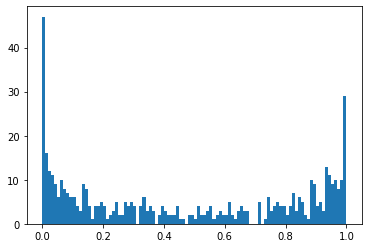

Plot ROC...


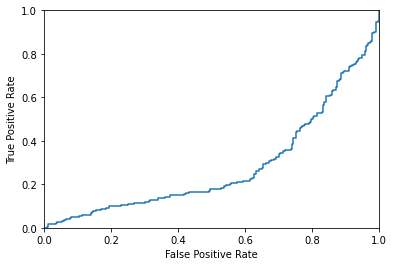

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

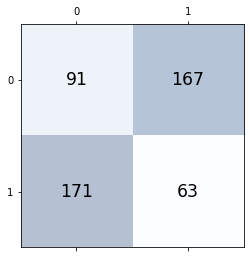

Plot Results...


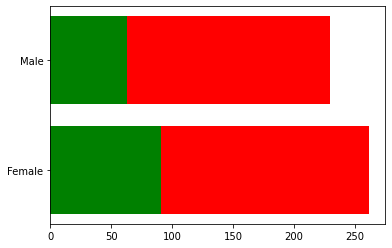


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.313
    
    True positives: 63.000
    False positives: 167.000
    
    True negatives: 91.000
    False negatives: 171.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.269
    True negative rate tn/(tn+fp): 0.353
    
    False negative rate fn/(tp+fn): 0.731
    False positive rate fp/(tn+fp): 0.647
    
    Positive predicted value tp/(tp+fp): 0.274
    False discovery rate fp/(tp+fp): 0.726
    
    Negative predicted value tn/(tn+fn): 0.347
    False omission rate fn/(tn+fn): 0.653
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -32.000
    Demographic parity tp+fp: 230.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.083
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.065
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.467
    
    Binary predictive rate parity diff 

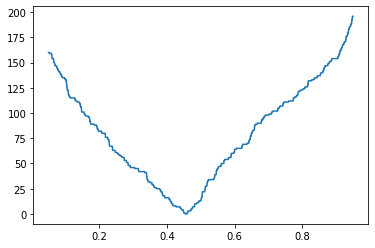

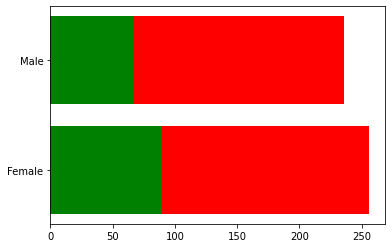


    Test results (Equal True):
    -------------
    
    Accuracy: 0.317
    
    True positives: 67.000
    False positives: 169.000
    
    True negatives: 89.000
    False negatives: 167.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.286
    True negative rate tn/(tn+fp): 0.345
    
    False negative rate fn/(tp+fn): 0.714
    False positive rate fp/(tn+fp): 0.655
    
    Positive predicted value tp/(tp+fp): 0.284
    False discovery rate fp/(tp+fp): 0.716
    
    Negative predicted value tn/(tn+fn): 0.348
    False omission rate fn/(tn+fn): 0.652
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -20.000
    Demographic parity tp+fp: 236.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.059
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.041
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.480
    
    Binary predictive rate parity diff (tp/(tp+fp))-(

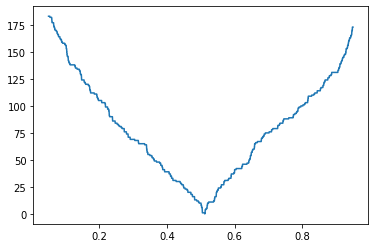

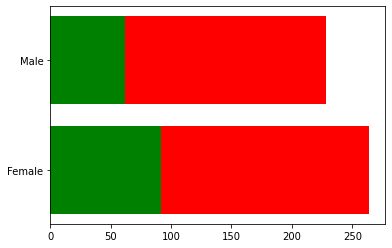


    Test results (Equal False):
    -------------
    
    Accuracy: 0.313
    
    True positives: 62.000
    False positives: 166.000
    
    True negatives: 92.000
    False negatives: 172.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.265
    True negative rate tn/(tn+fp): 0.357
    
    False negative rate fn/(tp+fn): 0.735
    False positive rate fp/(tn+fp): 0.643
    
    Positive predicted value tp/(tp+fp): 0.272
    False discovery rate fp/(tp+fp): 0.728
    
    Negative predicted value tn/(tn+fn): 0.348
    False omission rate fn/(tn+fn): 0.652
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -36.000
    Demographic parity tp+fp: 228.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.092
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.073
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.463
    
    Binary predictive rate parity diff (tp/(tp+fp))-

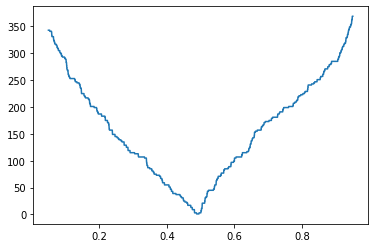

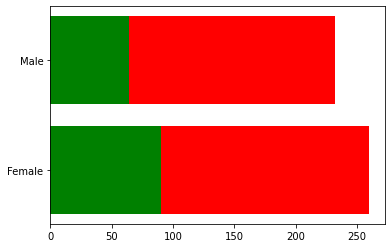


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.313
    
    True positives: 64.000
    False positives: 168.000
    
    True negatives: 90.000
    False negatives: 170.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.274
    True negative rate tn/(tn+fp): 0.349
    
    False negative rate fn/(tp+fn): 0.726
    False positive rate fp/(tn+fp): 0.651
    
    Positive predicted value tp/(tp+fp): 0.276
    False discovery rate fp/(tp+fp): 0.724
    
    Negative predicted value tn/(tn+fn): 0.346
    False omission rate fn/(tn+fn): 0.654
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -28.000
    Demographic parity tp+fp: 232.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.075
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.057
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.472
    
    Binary predictive rate parity diff (tp/(tp+fp))-

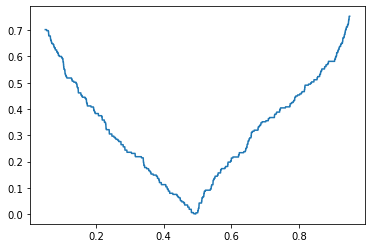

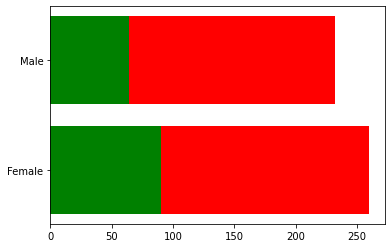


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.313
    
    True positives: 64.000
    False positives: 168.000
    
    True negatives: 90.000
    False negatives: 170.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.274
    True negative rate tn/(tn+fp): 0.349
    
    False negative rate fn/(tp+fn): 0.726
    False positive rate fp/(tn+fp): 0.651
    
    Positive predicted value tp/(tp+fp): 0.276
    False discovery rate fp/(tp+fp): 0.724
    
    Negative predicted value tn/(tn+fn): 0.346
    False omission rate fn/(tn+fn): 0.654
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -28.000
    Demographic parity tp+fp: 232.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.075
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.057
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.472
    
    Binary predictive rate parity diff (tp/(tp+fp))-(

<Figure size 432x288 with 0 Axes>

In [8]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)